In [1]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean
from xgcm import Grid

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## Reading in data for parameterized runs:

In [74]:
#/neerajab/NeverWorld2/runGM/run1 has KHTH=100
#/neerajab/NeverWorld2/runGM/run3 has KHTH=500
#/neerajab/NeverWorld2/runGM/run6 has KHTH=2500
#/neerajab/NeverWorld2/runGM/run7 has KHTH=5000

#TUNED VERSIONS:
#/gmarques/NeverWorld2/Visbeck/nw2_0.5deg_N15_Visbeck_run3      TUNED! has Visbeck scheme on
#/gmarques/NeverWorld2/GEOMETRIC/nw2_0.5deg_N15_GEOMETRIC_run3  TUNED! has Geometric scheme (Marshall et al. 2012)
#/gmarques/NeverWorld2/TMEKE/nw2_0.5deg_N15_TMEKE_run3          TUNED! has MEKE+GM from Jansen et al. (topographic beta in rhines scale=topographic MEKE)

#not working or untuned:
#/gmarques/NeverWorld2/DM07/nw2_0.5deg_N15_DM07_run2           !NOT TUNED has Danabasoglu & Marshall 2007 stratification based scheme on
#/gmarques/NeverWorld2/nw2_0.5deg_N15_MEKE_OM4                 has OM4_p5 settings except FGNV is off...
#/gmarques/NeverWorld2/nw2_0.5deg_N15_QG_Leith  has QG Leith scheme on but not working?


%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/runGM/run7

fs=xr.open_dataset('static.nc', decode_times=False)
os=xr.open_dataset('ocean.stats.nc', decode_times=False)
#av=xr.open_dataset('averages_00028502.nc',decode_times=False)
av=xr.open_dataset('averages_00031502.nc',decode_times=False)

%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/neerajab/NeverWorld2/runGM/run7
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


## Reading in data for truth case (1/32 degree):

In [92]:
# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.03125deg_N15_baseline/
# fs = xr.open_dataset('static.nc', decode_times=False)
# os = xr.open_dataset('ocean.stats.nc', decode_times=False)
# av = xr.open_dataset('averages_00001202.nc', decode_times=False)
# %cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.25deg_N15_baseline/
fs = xr.open_dataset('static.nc', decode_times=False)
os = xr.open_dataset('ocean.stats.nc', decode_times=False)
av = xr.open_dataset('averages_00031502.nc', decode_times=False)  
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/


/glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.25deg_N15_baseline
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [93]:

grid= Grid(av, coords={'X': {'center': 'xh', 'outer': 'xq'}, #This tells the grid where xh, xq, yh, and yq are defined.
                        'Y': {'center': 'yh', 'outer': 'yq'}});


In [94]:
#Read in various grid variables from the static file and forcing:
Nlayers=15
lon=fs['geolon']; lat=fs['geolat']
depth = fs['depth_ocean']
#depthmat = np.tile(depth,[100,15,1,1])
depthmat = np.tile(depth,[15,1,1])

#print(depthmat.shape)
area_t=fs['area_t']

xh = fs.xh.values
yh = fs.yh.values

interface_ref=os['H0']#.values; 
interface_ref=interface_ref[-1,:-1]
interface_ref_mat=np.transpose(np.tile(interface_ref,[len(yh),len(xh),1]),[2,0,1])

#interface_ref_mat=np.transpose(np.tile(interface_ref,[len(yh),len(xh),100,1]),[2,3,0,1])
print(interface_ref_mat.shape)


Layer = (os['Layer']);
drho=av['h'][0,:,0,0]*0.;
drho[0]=Layer[0].values; 
drho[1:]=np.diff((Layer),axis=0)
print(drho); #drho contains the density differences across each interface. 15 entries, includes surface but not bottom.
#drhomat=np.transpose(np.tile(drho,[len(yh),len(xh),1]),[2,0,1])

(15, 560, 240)
<xarray.DataArray 'h' (zl: 15)>
array([1.0226e+03, 2.1000e-01, 3.9000e-01, 5.4000e-01, 5.8000e-01,
       5.8000e-01, 5.7000e-01, 5.3000e-01, 4.8000e-01, 4.2000e-01,
       3.7000e-01, 3.1000e-01, 2.4000e-01, 1.7000e-01, 1.1000e-01],
      dtype=float32)
Coordinates:
    yh       float64 -69.88
  * zl       (zl) float64 1.023e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
    time     float64 3.15e+04
    xh       float64 0.125


In [95]:
%%time
h = av['h']; #h[np.isnan(h)]=0.0
correction  = (interface_ref_mat-depthmat); #if >0 this means h_ref is deeper than topography, we need correction!
correction[correction<0]=0.0 #if correction <0 that means depth is larger than h_ref, we don't need correction!

interface = (h)*0.0;
for i in range(0,len(Layer)):
    interface[:,i,:,:]=(h[:,i:,:,:]).sum(axis=1)-depth
#interface is negative down, interface_ref_mat is positive down
    #print(t)

interface_ref_HIC = interface_ref_mat- correction
eta_mean=(interface+interface_ref_HIC).mean(axis=0)
eta_eddy=(interface+interface_ref_HIC)- eta_mean;

eta2_mean = (eta_mean**2.)
eta2_eddy = (eta_eddy**2.).mean(axis=0)
print(eta2_mean.shape,eta2_eddy.shape)

APE_mean = 0.5*9.81*(drho)*eta2_mean/(1022.6*depth)
APE_eddy = 0.5*9.81*(drho)*eta2_eddy/(1022.6*depth)
APE_mean  =np.nansum(APE_mean,axis=0)#*area_t
APE_eddy  =np.nansum(APE_eddy,axis=0)#*area_t

print('done')

(15, 560, 240) (15, 560, 240)
done
CPU times: user 8.04 s, sys: 5.22 s, total: 13.3 s
Wall time: 16.6 s


In [96]:
APE_mean.shape

(560, 240)

In [97]:
np.nanmean(APE_eddy)

0.004366563764332266

In [98]:
%%time
# #COMPUTE velocity components for decomposing KE:
Nlayers=15

h  = av['h'].mean('time').fillna(0.)
Depth=h.sum('zl')
print('done part 1')
#Outputs are comprised of 100 5-day averages.
u  = av['u'];  u = grid.interp(u,axis='X')#.fillna(0.); 
ubar=u.mean('time')
print('done part 2')
v  = av['v'];  v = grid.interp(v,axis='Y')#.fillna(0.);
vbar=v.mean('time')

uprime=u-ubar
vprime=v-vbar

print(uprime.shape)
area_t=fs['area_t']

done part 1
done part 2
(100, 15, 560, 240)
CPU times: user 8.76 s, sys: 4.71 s, total: 13.5 s
Wall time: 45.6 s


In [99]:
%%time
# The mean BT and BC KE values:
ubar_TW=ubar*h/Depth; 
ubar_BT=ubar_TW.sum('zl')
ubar_BC=ubar-ubar_BT;

vbar_TW=vbar*h/Depth
vbar_BT=vbar_TW.sum('zl')
vbar_BC=vbar-vbar_BT;

KE_mean_BT=0.5*(vbar_BT**2+ubar_BT**2) #dim y,x
KE_mean_BC=(0.5*(vbar_BC**2+ubar_BC**2)*h/Depth).sum('zl') #dim y,x

print('done 1')

#Eddy BT and BC KE parts:
uprime_BT=(uprime*h/Depth).sum('zl')
uprime_BC=uprime-uprime_BT
vprime_BT=(vprime*h/Depth).sum('zl')
vprime_BC=vprime-vprime_BT
    
KE_eddy_BT=(0.5*(vprime_BT**2+uprime_BT**2)).mean('time')
KE_eddy_BC=((0.5*(vprime_BC**2+uprime_BC**2)*h/Depth).sum('zl')).mean('time')


# #Total kinetic energy:
KE_BT_tot=KE_eddy_BT+KE_mean_BT
KE_BC_tot=KE_eddy_BC+KE_mean_BC
KE_tot=KE_BT_tot+KE_BC_tot


fraction_BT=KE_BT_tot/KE_tot
fraction_BT_mean=KE_mean_BT/KE_tot
fraction_BT_eddy=KE_eddy_BT/KE_tot

fraction_BC=KE_BC_tot/KE_tot#when you divide zero/zero it's a nan
fraction_BC_mean=KE_mean_BC/KE_tot
fraction_BC_eddy=KE_eddy_BC/KE_tot

KE_eddy = KE_eddy_BT+ KE_eddy_BC
KE_mean = KE_mean_BT+ KE_eddy_BC

done 1
CPU times: user 2.78 s, sys: 3.52 s, total: 6.3 s
Wall time: 6.3 s


In [100]:
APE_mean_025= APE_mean
APE_eddy_025= APE_eddy

KE_mean_025 = KE_mean
KE_eddy_025= KE_eddy
yh_025 = yh
print('done')

done


Text(0, 0.5, '[$m^2/s^2$]')

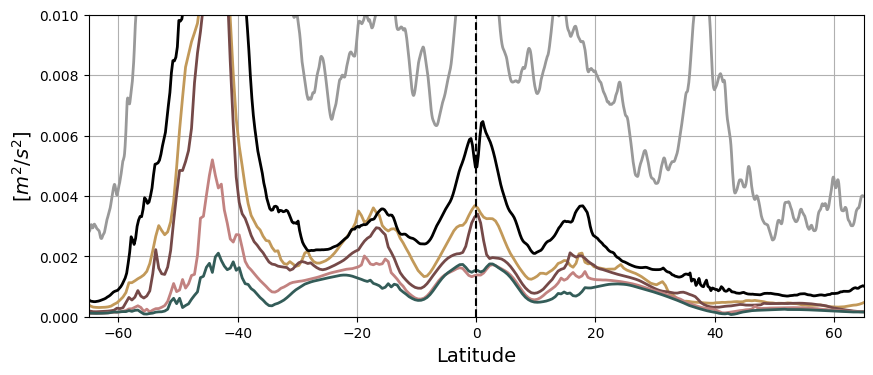

In [152]:
plt.figure(figsize=(10, 6), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh_GM100,(KE_mean_GM100+KE_eddy_GM100).mean(axis=1),'-',c='#C29959',linewidth=2)
plt.plot(yh_GM500,(KE_mean_GM500+KE_eddy_GM500).mean(axis=1),'-',c='#754948',linewidth=2)
plt.plot(yh_GM2500,(KE_mean_GM2500+KE_eddy_GM2500).mean(axis=1),'-',color='#C28280',linewidth=2)
plt.plot(yh_GM5000,(KE_mean_GM5000+KE_eddy_GM5000).mean(axis=1),'-',color='#335C58',linewidth=2)

plt.plot(yh_025,(KE_mean_025+KE_eddy_025).mean(axis=1),'-',color='k',linewidth=2)
plt.plot(yh_003125,(KE_mean_003125+KE_eddy_003125).mean(axis=1),'-',c=[.6,.6,.6],linewidth=2)


plt.grid()

plt.legend(['$K_{GM}=100$','$K_{GM}=500$','$K_{GM}=2500$','$K_{GM}=5000$','$1/4^\circ$','$1/32^\circ$'],loc='upper right',fontsize=12)
plt.plot([0, 0],[0, 10],'--',color=[0,0,0])
plt.xlim(-65,65)
plt.ylim(0,.05);
plt.xlabel('Latitude',fontsize=14)
plt.ylabel('[$m^2/s^2$]',fontsize=14)
plt.title('Kinetic Energy',fontsize=14)

Text(0.5, 1.0, 'Kinetic Energy')

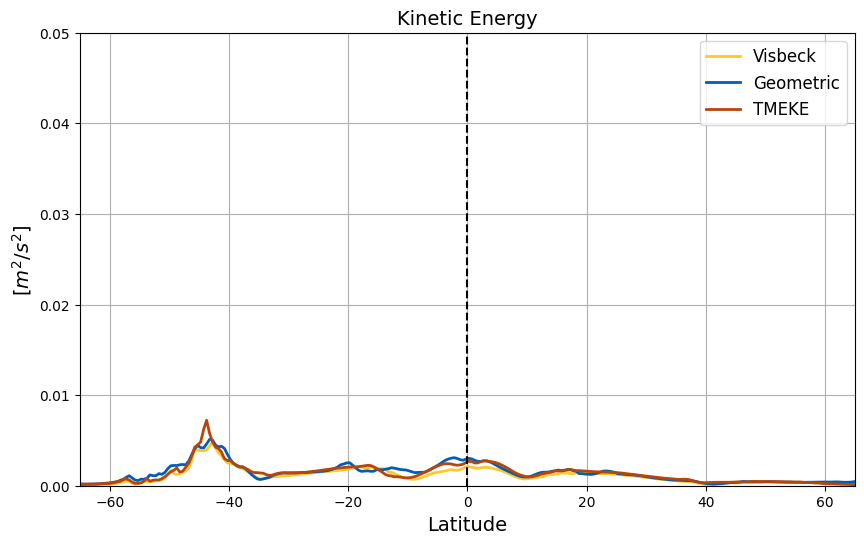

In [45]:
plt.figure(figsize=(10, 6), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh_Visbeck,(KE_mean_Visbeck+KE_eddy_Visbeck).mean(axis=1),'-',c='#FFC72C',linewidth=2)
plt.plot(yh_GEOM,(KE_mean_GEOM+KE_eddy_GEOM).mean(axis=1),'-',c='#005EB8',linewidth=2)
plt.plot(yh_TMEKE,(KE_mean_TMEKE+KE_eddy_TMEKE).mean(axis=1),'-',color='#B84509',linewidth=2)

#plt.plot(yh_025,(KE_mean_025+KE_eddy_025).mean(axis=1),'-',color='k',linewidth=2)
#plt.plot(yh_003125,(KE_mean_003125+KE_eddy_003125).mean(axis=1),'-',c=[.6,.6,.6],linewidth=2)


plt.grid()
plt.legend(['Visbeck','Geometric','TMEKE','$1/4^\circ$','$1/32^\circ$'],loc='upper right',fontsize=12)
plt.plot([0, 0],[0, 10],'--',color=[0,0,0])
plt.xlim(-65,65)
plt.ylim(0,.05);
plt.xlabel('Latitude',fontsize=14)
plt.ylabel('[$m^2/s^2$]',fontsize=14)
plt.title('Kinetic Energy',fontsize=14)

Text(0, 0.5, '[$m^2/s^2$]')

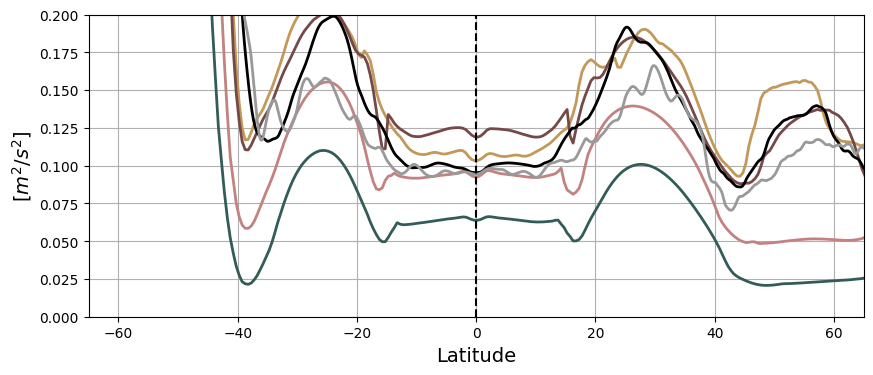

In [123]:
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh_GM100,(APE_mean_GM100+APE_eddy_GM100).mean(axis=1),'-',c='#C29959',linewidth=2)
plt.plot(yh_GM500,(APE_mean_GM500+APE_eddy_GM500).mean(axis=1),'-',c='#754948',linewidth=2)
plt.plot(yh_GM2500,(APE_mean_GM2500+APE_eddy_GM2500).mean(axis=1),'-',color='#C28280',linewidth=2)
plt.plot(yh_GM5000,(APE_mean_GM5000+APE_eddy_GM5000).mean(axis=1),'-',color='#335C58',linewidth=2)

plt.plot(yh_025,(APE_mean_025+APE_eddy_025).mean(axis=1),'-',color='k',linewidth=2)
plt.plot(yh_003125,(APE_mean_003125+APE_eddy_003125).mean(axis=1),'-',c=[.6,.6,.6],linewidth=2)


plt.grid()

#plt.legend(['$K_{GM}=100$','$K_{GM}=500$','$K_{GM}=2500$','$K_{GM}=5000$','$1/4^\circ$','$1/32^\circ$'],loc='upper right',fontsize=12)
plt.plot([0, 0],[0, 10],'--',color=[0,0,0])
plt.xlim(-65,65)
plt.ylim(0,.2);
plt.xlabel('Latitude',fontsize=14)
plt.ylabel('[$m^2/s^2$]',fontsize=14)
#plt.title('Available Potential Energy',fontsize=14)

Text(0, 0.5, '[$m^2/s^2$]')

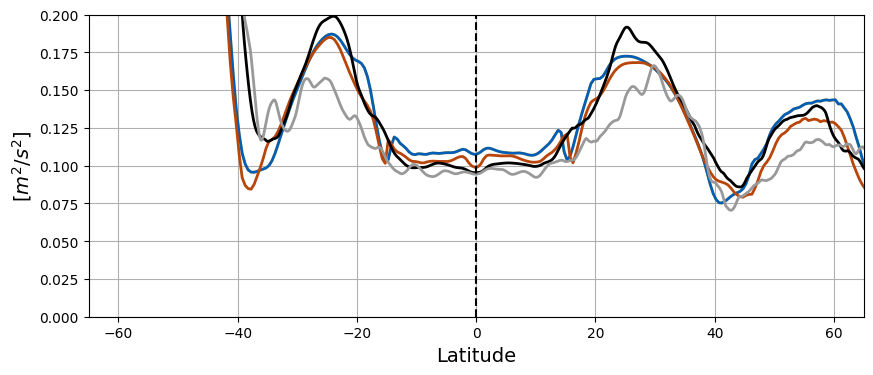

In [112]:
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
APE_mean_003125[940,:]=APE_mean_003125[941,:]; APE_mean_003125[955,:]=APE_mean_003125[956,:];

plt.plot(yh_Visbeck,(APE_mean_Visbeck+APE_eddy_Visbeck).mean(axis=1),'-',c='#FFC72C',linewidth=2)
plt.plot(yh_GEOM,(APE_mean_GEOM+APE_eddy_GEOM).mean(axis=1),'-',c='#005EB8',linewidth=2)
plt.plot(yh_TMEKE,(APE_mean_TMEKE+APE_eddy_TMEKE).mean(axis=1),'-',color='#B84509',linewidth=2)

plt.plot(yh_025,(APE_mean_025+APE_eddy_025).mean(axis=1),'-',color='k',linewidth=2)
plt.plot(yh_003125,(APE_mean_003125+APE_eddy_003125).mean(axis=1),'-',c=[.6,.6,.6],linewidth=2)

# plt.plot(yh_Visbeck,(APE_mean_Visbeck).mean(axis=1),'-',c='#FFC72C',linewidth=2)
# plt.plot(yh_GEOM,(APE_mean_GEOM).mean(axis=1),'-',c='#005EB8',linewidth=2)
# plt.plot(yh_TMEKE,(APE_mean_TMEKE).mean(axis=1),'-',color='#B84509',linewidth=2)

# plt.plot(yh_025,(APE_mean_025).mean(axis=1),'-',color='k',linewidth=2)
# plt.plot(yh_003125,(APE_mean_003125).mean(axis=1),'-',c=[.6,.6,.6],linewidth=2)

plt.grid()
#plt.legend(['Visbeck','Geometric','TMEKE','$1/4^\circ$','$1/32^\circ$'],loc='upper right',fontsize=12)
plt.plot([0, 0],[0, 10],'--',color=[0,0,0])
plt.xlim(-65,65)
plt.ylim(0,.2);
plt.xlabel('Latitude',fontsize=14)
plt.ylabel('[$m^2/s^2$]',fontsize=14)
#plt.title('Available Potential Energy',fontsize=14)

Text(0.5, 1.0, 'Available Potential Energy')

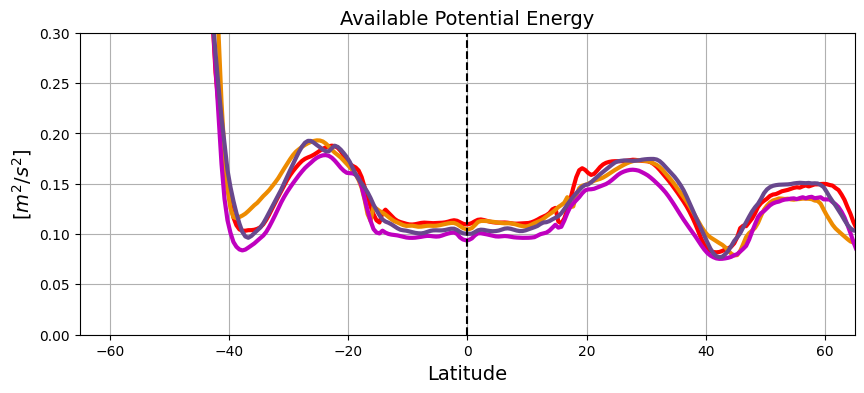

In [188]:
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh_Visbeck,np.nanmean(APE_mean_Visbeck+APE_eddy_Visbeck,axis=1),'-',color='r',linewidth=3)
plt.plot(yh_DM07,np.nanmean(APE_mean_DM07+APE_eddy_DM07,axis=1),'-',color='#ED8B00',linewidth=3)
plt.plot(yh_MEKE,np.nanmean(APE_mean_MEKE+APE_eddy_MEKE,axis=1),'-',c='m',linewidth=3)
plt.plot(yh_GEOM,np.nanmean(APE_mean_GEOM+APE_eddy_GEOM,axis=1),'-',c='#68478D',linewidth=3)


plt.grid()
#plt.plot(yh_00625,np.convolve(np.nanmean(KE_tot_test_00625,axis=1), np.ones((window,))/window, mode='same'),':',c='k',linewidth=3)

#plt.legend(['KE_tot 1/4 $^\circ$','KE_tot_ref 1/4$^\circ$','KE_tot 1/16 $^\circ$','KE_tot_ref 1/16$^\circ$'],loc='upper right',fontsize=8)
plt.plot([0, 0],[0, 10],'--',color=[0,0,0])
plt.xlim(-65,65)

plt.ylim(0,.3);
plt.xlabel('Latitude',fontsize=14)
plt.ylabel('[$m^2/s^2$]',fontsize=14)
plt.title('Available Potential Energy',fontsize=14)

In [61]:
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh,np.nanmean(APE_eddy_GM100,axis=1)/np.nanmean(KE_eddy_GM100,axis=1),'-',color='g',linewidth=3)
plt.plot(yh,np.nanmean(APE_eddy_GM500,axis=1)/np.nanmean(KE_eddy_GM500,axis=1),'-',color='c',linewidth=3)
plt.plot(yh,np.nanmean(APE_eddy_GM2500,axis=1)/np.nanmean(KE_eddy_GM2500,axis=1),'-',c='#4B68B8',linewidth=3)
plt.plot(yh,np.nanmean(APE_eddy_GM5000,axis=1)/np.nanmean(KE_eddy_GM5000,axis=1),'-',c='#532D84',linewidth=3)


plt.grid()

plt.plot([0, 0],[0, 10000],'--',color=[0,0,0])
plt.plot([-70, 70],[1, 1],':',color=[0,0,0])

plt.xlim(-65,65)

plt.ylim(0,60);
plt.xlabel('Latitude',fontsize=14)
#plt.ylabel('APE/KE')
plt.title('Eddy APE to Eddy KE Ratio',fontsize=14)

NameError: name 'APE_eddy_GM100' is not defined

<Figure size 1000x400 with 0 Axes>

Text(0.5, 1.0, 'Eddy APE to Eddy KE Ratio')

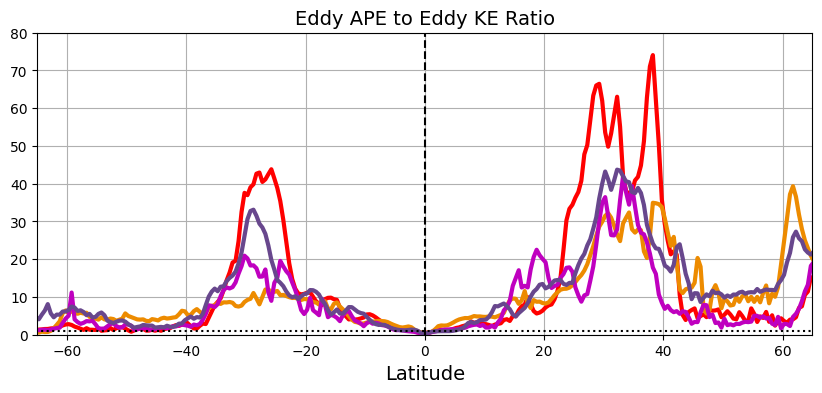

In [187]:
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh,np.nanmean(APE_eddy_Visbeck,axis=1)/np.nanmean(KE_eddy_Visbeck,axis=1),'-',color='r',linewidth=3)
plt.plot(yh,np.nanmean(APE_eddy_DM07,axis=1)/np.nanmean(KE_eddy_DM07,axis=1),'-',color='#ED8B00',linewidth=3)
plt.plot(yh,np.nanmean(APE_eddy_MEKE,axis=1)/np.nanmean(KE_eddy_MEKE,axis=1),'-',c='m',linewidth=3)
plt.plot(yh,np.nanmean(APE_eddy_GEOM,axis=1)/np.nanmean(KE_eddy_GEOM,axis=1),'-',c='#68478D',linewidth=3)


plt.grid()

plt.plot([0, 0],[0, 10000],'--',color=[0,0,0])
plt.plot([-70, 70],[1, 1],':',color=[0,0,0])

plt.xlim(-65,65)

plt.ylim(0,80);
plt.xlabel('Latitude',fontsize=14)
#plt.ylabel('APE/KE')
plt.title('Eddy APE to Eddy KE Ratio',fontsize=14)

Text(0.5, 1.0, 'Kinetic Energy')

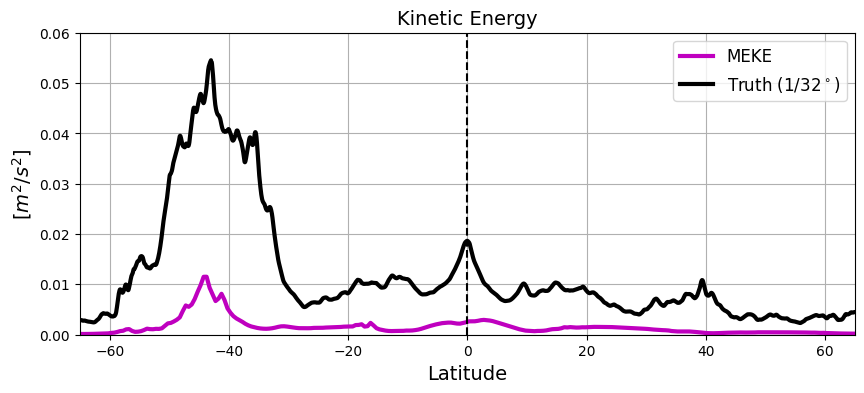

In [211]:
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh,(KE_mean_MEKE+KE_eddy_MEKE).mean(axis=1),'-',color='m',linewidth=3)
plt.plot(yh_true,(KE_mean_true+KE_eddy_true).mean(axis=1),'-',color='k',linewidth=3)



plt.grid()

plt.legend(['MEKE','Truth (1/32$^\circ$)'],loc='upper right',fontsize=12)
plt.plot([0, 0],[0, 10],'--',color=[0,0,0])
plt.xlim(-65,65)
plt.ylim(0,.06);
plt.xlabel('Latitude',fontsize=14)
plt.ylabel('[$m^2/s^2$]',fontsize=14)
plt.title('Kinetic Energy',fontsize=14)

Text(0.5, 1.0, 'Available Potential Energy')

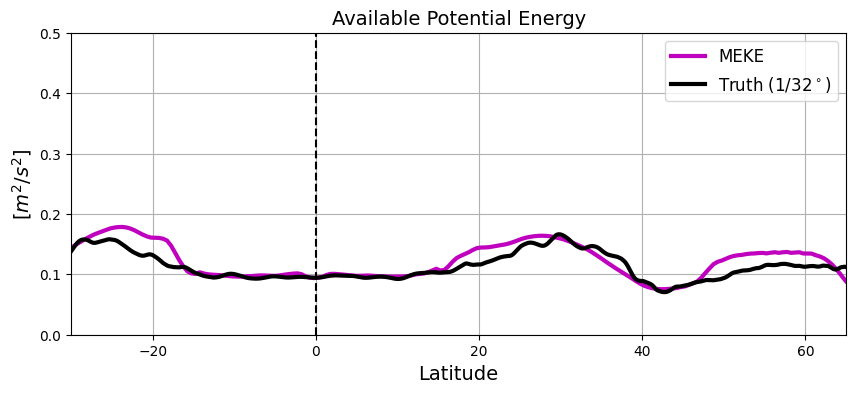

In [60]:
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh,np.nanmean(APE_mean_MEKE+APE_eddy_MEKE,axis=1),'-',color='m',linewidth=3)
APE_final_true = np.nanmean(APE_mean_true+APE_eddy_true,axis=1)
APE_final_true[940]=APE_final_true[941]; APE_final_true[955]=APE_final_true[956];
plt.plot(yh_true,APE_final_true,'-',color='k',linewidth=3)


plt.grid()

plt.legend(['MEKE','Truth (1/32$^\circ$)'],loc='upper right',fontsize=12)
plt.plot([0, 0],[0, 10],'--',color=[0,0,0])
plt.xlim(-30,65)

plt.ylim(0,.5);
plt.xlabel('Latitude',fontsize=14)
plt.ylabel('[$m^2/s^2$]',fontsize=14)
plt.title('Available Potential Energy',fontsize=14)

Text(0.5, 1.0, 'Eddy APE to Eddy KE Ratio')

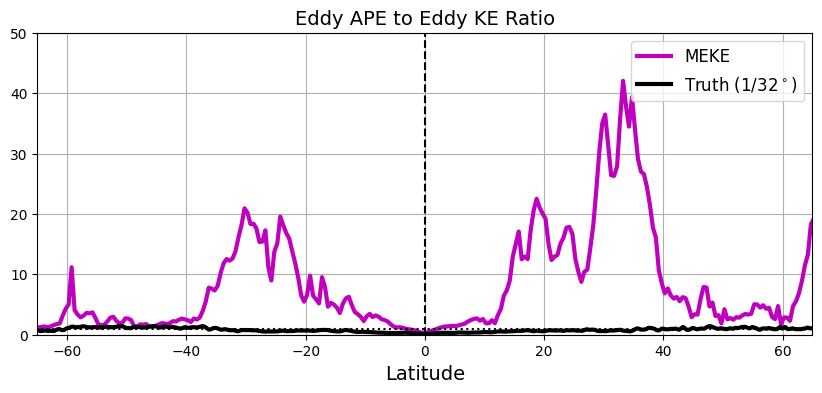

In [63]:
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(yh,np.nanmean(APE_eddy_MEKE,axis=1)/np.nanmean(KE_eddy_MEKE,axis=1),'-',color='m',linewidth=3)
plt.plot(yh_true,np.nanmean(APE_eddy_true,axis=1)/np.nanmean(KE_eddy_true,axis=1),'-',color='k',linewidth=3)

plt.grid()

plt.plot([0, 0],[0, 10000],'--',color=[0,0,0])
plt.plot([-70, 70],[1, 1],':',color=[0,0,0])

plt.xlim(-65,65)

plt.ylim(0,50);
plt.xlabel('Latitude',fontsize=14)
plt.legend(['MEKE','Truth (1/32$^\circ$)'],loc='upper right',fontsize=12)
plt.title('Eddy APE to Eddy KE Ratio',fontsize=14)